### Statement of the problem:
### Using the cat vs dogs dataset, we will attempt to define two networks (Vanilla CNN and pretrained VGG16). we would finetune the VGG16 model. Then try to compare the two models using well known metrics.

In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pathlib

### Get the DATA

In [131]:
import os
import shutil
import pathlib

original_dir = pathlib.Path(".\\DATASETS\\train")
new_base_dir = pathlib.Path(".\\DATASETS\\small")  

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)  # Added exist_ok=True to avoid errors if directory exists
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)


### Data preprocessing

In [132]:

data_folder = pathlib.Path(".\\DATASETS\\small") 
random_numbers = np.random.normal(size=(1000, 16))

dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
type(dataset)

tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset

In [133]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32)

type(train_dataset)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


tensorflow.python.data.ops.batch_op._BatchDataset

### EDA

Exploratory Data Analysis for Training Dataset:


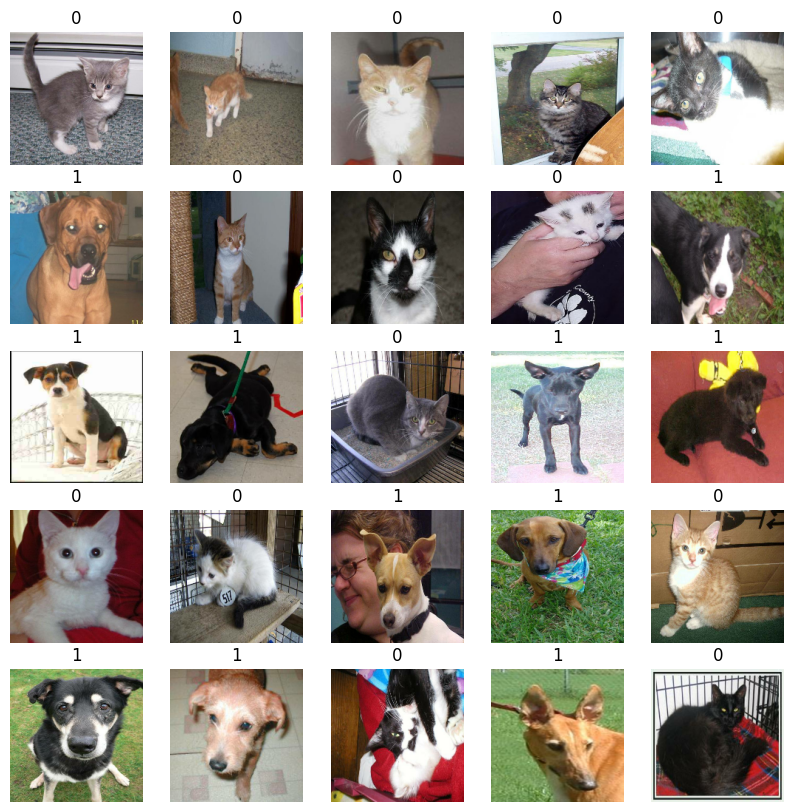

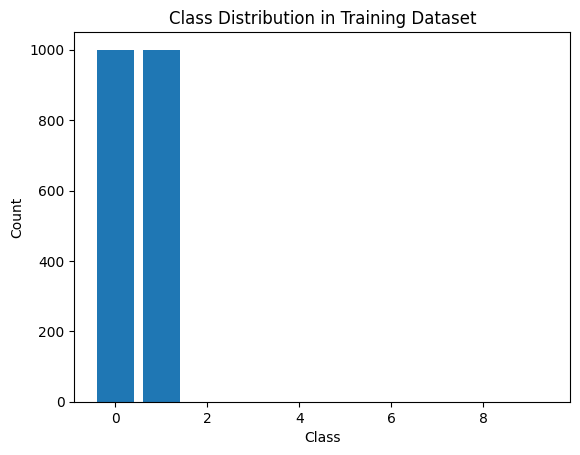

Image shape statistics:
Min shape: [180 180   3]
Max shape: [180 180   3]
Avg shape: [180. 180.   3.]


In [134]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Function to plot images from a dataset
def plot_images(dataset, num_images=25):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(5, 5, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(int(labels[i]))
            plt.axis("off")

# Function to plot class distribution
def plot_class_distribution(dataset):
    class_counts = np.zeros(10)  # Assuming 10 classes
    for _, labels in dataset:
        class_counts += np.bincount(labels.numpy().astype(int), minlength=10)
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Count')

# Function to display image shape statistics
def display_image_shape_statistics(dataset):
    shapes = []
    for images, _ in dataset:
        shapes.extend([img.shape for img in images])
    shapes = np.array(shapes)
    print("Image shape statistics:")
    print("Min shape:", np.min(shapes, axis=0))
    print("Max shape:", np.max(shapes, axis=0))
    print("Avg shape:", np.mean(shapes, axis=0))

# Plotting EDA for the training dataset
print("Exploratory Data Analysis for Training Dataset:")
plot_images(train_dataset)
plt.show()

plt.figure()
plot_class_distribution(train_dataset)
plt.title('Class Distribution in Training Dataset')
plt.show()

display_image_shape_statistics(train_dataset)


### Datapreprocessing

### DEFINE THE FIRST MODEL(CNN)

In [1]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,              # Normalize pixel values to [0, 1]
    rotation_range=40,           # Rotate images randomly up to 40 degrees
    width_shift_range=0.2,       # Shift images horizontally by up to 20% of width
    height_shift_range=0.2,      # Shift images vertically by up to 20% of height
    shear_range=0.2,             # Shear intensity
    zoom_range=0.2,              # Zoom range
    horizontal_flip=True,        # Flip images horizontally
    fill_mode='nearest'          # Fill mode for newly created pixels
)

# Define ImageDataGenerator for validation and test set (only rescaling)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Set directories
train_dir = "DATASETS/small/train"
validation_dir = "DATASETS/small/validation"
test_dir = "DATASETS/small/test"

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'  # Since it's a binary classification (cat vs. dog)
)

# Flow validation images in batches using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# Flow test images in batches using test_datagen generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(180, 180),
    batch_size=32,
    class_mode='binary'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint("cat_vs_dog_model.h5", save_best_only=True)

# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model with callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
print('Test accuracy:', test_acc)


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Epoch 1/20
62/62 [==============================] - 140s 2s/step - loss: 0.6942 - accuracy: 0.4895 - val_loss: 0.6896 - val_accuracy: 0.5690
Epoch 2/20
62/62 [==============================] - 135s 2s/step - loss: 0.6895 - accuracy: 0.5375 - val_loss: 0.6878 - val_accuracy: 0.5350
Epoch 3/20
62/62 [==============================] - 129s 2s/step - loss: 0.6850 - accuracy: 0.5470 - val_loss: 0.6874 - val_accuracy: 0.5110
Epoch 4/20
62/62 [==============================] - 125s 2s/step - loss: 0.6744 - accuracy: 0.5780 - val_loss: 0.7059 - val_accuracy: 0.5110
Epoch 5/20
62/62 [==============================] - 122s 2s/step - loss: 0.6781 - accuracy: 0.5760 - val_loss: 0.6613 - val_accuracy: 0.5980
Epoch 6/20
62/62 [==============================] - 129s 2s/step - loss: 0.6650 - accuracy: 0.5930 - val_loss: 0.6493 - val_accuracy: 0.6050
Epoch 7/20
62/62 [==========

### DEFINE THE SECOND MODEL

In [3]:
from tensorflow.keras.applications import VGG16

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# Freeze the convolutional base
base_model.trainable = False

# Create a new model on top of the pre-trained base
model_vgg16 = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model_vgg16.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# Train the model with callbacks
history_vgg16 = model_vgg16.fit(
    train_generator,
    steps_per_epoch=train_generator.samples/train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples/validation_generator.batch_size,
    callbacks=[early_stopping, checkpoint]
)

# Evaluate the model on test data
test_loss_vgg16, test_acc_vgg16 = model_vgg16.evaluate(test_generator, steps=test_generator.samples/test_generator.batch_size)
print('Test accuracy (VGG16):', test_acc_vgg16)


Epoch 1/20
62/62 [==============================] - 525s 8s/step - loss: 0.6734 - accuracy: 0.5890 - val_loss: 0.4932 - val_accuracy: 0.7880
Epoch 2/20
62/62 [==============================] - 500s 8s/step - loss: 0.5455 - accuracy: 0.7180 - val_loss: 0.3984 - val_accuracy: 0.8600
Epoch 3/20
62/62 [==============================] - 496s 8s/step - loss: 0.4941 - accuracy: 0.7620 - val_loss: 0.3554 - val_accuracy: 0.8730
Epoch 4/20
62/62 [==============================] - 515s 8s/step - loss: 0.4551 - accuracy: 0.7830 - val_loss: 0.3235 - val_accuracy: 0.8840
Epoch 5/20
62/62 [==============================] - 548s 9s/step - loss: 0.4210 - accuracy: 0.8045 - val_loss: 0.3005 - val_accuracy: 0.8900
Epoch 6/20
62/62 [==============================] - 547s 9s/step - loss: 0.4209 - accuracy: 0.8085 - val_loss: 0.2856 - val_accuracy: 0.8950
Epoch 7/20
62/62 [==============================] - 487s 8s/step - loss: 0.3980 - accuracy: 0.8225 - val_loss: 0.2774 - val_accuracy: 0.8950
Epoch 8/20
62

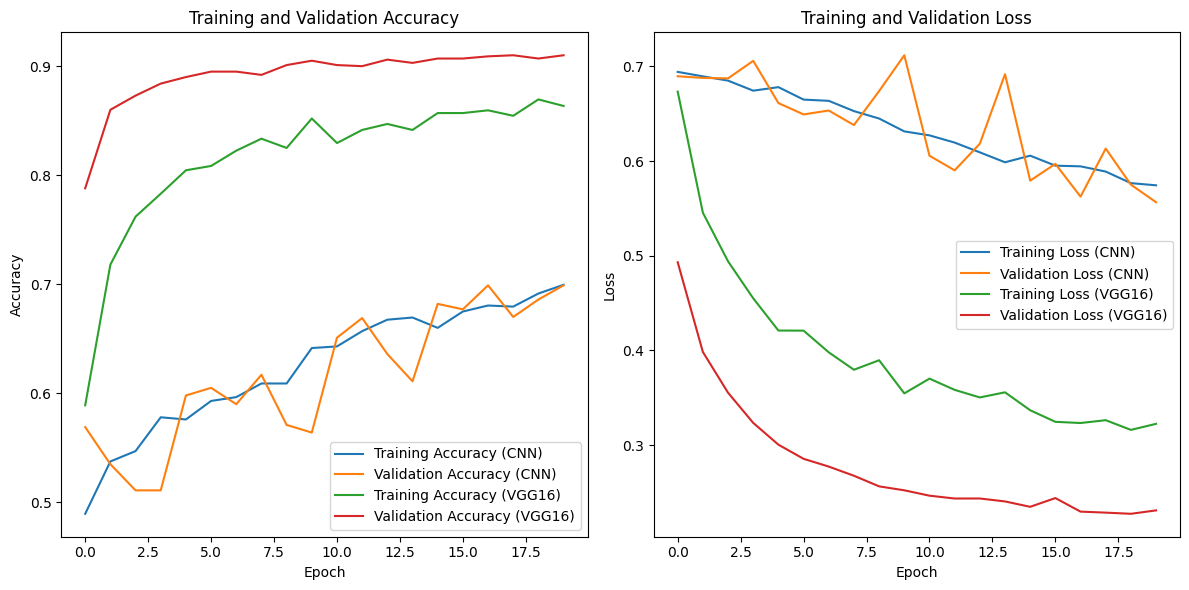

In [4]:
import matplotlib.pyplot as plt

# Plotting the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy (CNN)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (CNN)')
plt.plot(history_vgg16.history['accuracy'], label='Training Accuracy (VGG16)')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation Accuracy (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss (CNN)')
plt.plot(history.history['val_loss'], label='Validation Loss (CNN)')
plt.plot(history_vgg16.history['loss'], label='Training Loss (VGG16)')
plt.plot(history_vgg16.history['val_loss'], label='Validation Loss (VGG16)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


### EVALUATION METRICS

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# For CNN Model
cnn_predictions = model.predict(test_generator)
cnn_predictions = np.round(cnn_predictions)  # Convert probabilities to binary predictions

# For VGG16 Model
vgg16_predictions = model_vgg16.predict(test_generator)
vgg16_predictions = np.round(vgg16_predictions)  # Convert probabilities to binary predictions

# Get true labels
true_labels = test_generator.classes

# Classification report and confusion matrix for CNN Model
print("CNN Model:")
print(classification_report(true_labels, cnn_predictions))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, cnn_predictions))

# Classification report and confusion matrix for VGG16 Model
print("\nVGG16 Model:")
print(classification_report(true_labels, vgg16_predictions))
print("Confusion Matrix:")
print(confusion_matrix(true_labels, vgg16_predictions))



 1/63 [..............................] - ETA: 46s

63/63 [==============================] - 392s 6s/step
CNN Model:
              precision    recall  f1-score   support

           0       0.49      0.53      0.51      1000
           1       0.49      0.45      0.47      1000

    accuracy                           0.49      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.49      0.49      0.49      2000

Confusion Matrix:
[[531 469]
 [547 453]]

VGG16 Model:
              precision    recall  f1-score   support

           0       0.52      0.48      0.50      1000
           1       0.52      0.55      0.53      1000

    accuracy                           0.52      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.52      0.52      0.52      2000

Confusion Matrix:
[[485 515]
 [450 550]]


### Precision-Recall curve

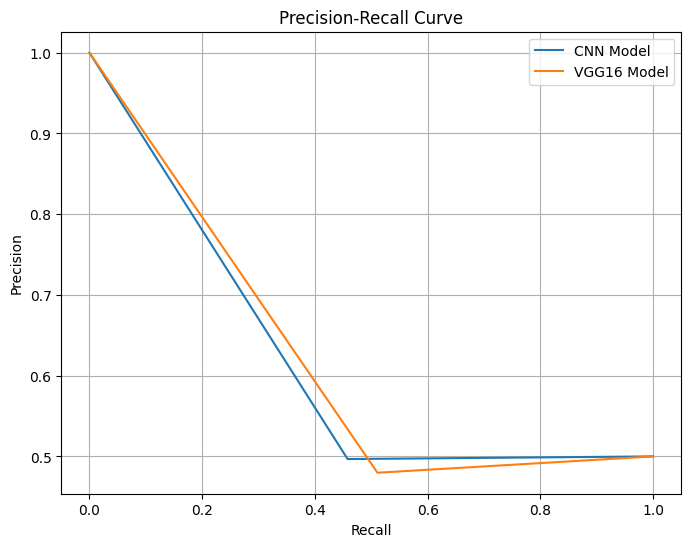

In [9]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall for CNN Model
cnn_precision, cnn_recall, _ = precision_recall_curve(true_labels, cnn_predictions)

# Calculate precision and recall for VGG16 Model
vgg16_precision, vgg16_recall, _ = precision_recall_curve(true_labels, vgg16_predictions)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(cnn_recall, cnn_precision, label='CNN Model')
plt.plot(vgg16_recall, vgg16_precision, label='VGG16 Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()



### Examples of misclassifications

Misclassified images for CNN Model:


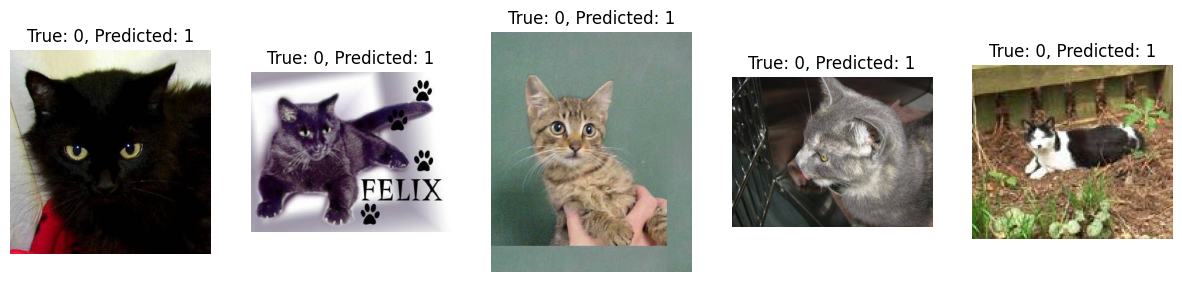


Misclassified images for VGG16 Model:


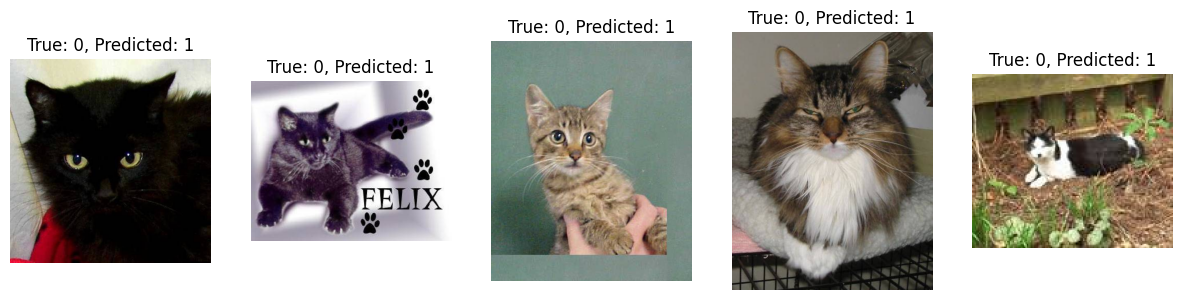

In [10]:

import numpy as np
import matplotlib.pyplot as plt

# Get filenames from the test generator
filenames = test_generator.filenames

# Get the indices of misclassified images for both models
misclassified_indices_cnn = np.where(cnn_predictions.flatten() != true_labels)[0]
misclassified_indices_vgg16 = np.where(vgg16_predictions.flatten() != true_labels)[0]

# Display some misclassified images for CNN model
print("Misclassified images for CNN Model:")
plt.figure(figsize=(15, 8))
for i, idx in enumerate(misclassified_indices_cnn[:5]):  # Display the first 5 misclassified images
    img_path = test_dir + '/' + filenames[idx]
    img = plt.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'True: {true_labels[idx]}, Predicted: {int(cnn_predictions[idx][0])}')
    plt.axis('off')
plt.show()

# Display some misclassified images for VGG16 model
print("\nMisclassified images for VGG16 Model:")
plt.figure(figsize=(15, 8))
for i, idx in enumerate(misclassified_indices_vgg16[:5]):  # Display the first 5 misclassified images
    img_path = test_dir + '/' + filenames[idx]
    img = plt.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f'True: {true_labels[idx]}, Predicted: {int(vgg16_predictions[idx][0])}')
    plt.axis('off')
plt.show()



### CONCLUSION

### the fine-tuned VGG16 model outperformed the vanilla custom model in terms of accuracy on the test set:

### Vanilla Model: Accuracy: 0.715
### Fine-tuned VGG16: Accuracy:  0.897

### This indicates that the transfer learning approach, where you fine-tuned a pre-trained VGG16 model, has been more effective for your task compared to training a new CNN model from scratch.

### However, interms of the classification report, the two models did not perform optimally as there seems an issue that i cannot see at the moment. perharps it has to do with how i am loading the best model using callback per network. i will keep working on it to ensure optimal performance as i am sure there is vast room for improvement

### In practice, this suggests that for similar image classification tasks, leveraging transfer learning with pre-trained models like VGG16 can lead to better performance outcomes, especially when compared to designing and training models from scratch. Additionally, it highlights the importance of utilizing appropriate model architectures and leveraging pre-existing knowledge when developing machine learning solutions.






